### Heatmap Generation

In [1]:
print("Hello")

Hello


In [2]:
pip install torch


   -------------------------------------- 162.6/162.6 MB 964.9 kB/s eta 0:00:00


In [1]:
import numpy as np
import torch

def generate_heatmap(img_size, kp, sigma=2, num_joints=17):
    """
    Generates a heatmap tensor of shape (num_joints, H, W)
    for a given set of keypoints.

    Args:
        img_size: Tuple (H, W)
        kp: numpy array of shape (num_joints, 2) with (x, y) coords
        sigma: Standard deviation of the Gaussian
    """
    H, W = img_size

    heatmap_size = 64  # match model output
    heatmaps = np.zeros((17, heatmap_size, heatmap_size),dtype=np.float32)
    # heatmaps = np.zeros((num_joints, H, W), dtype=np.float32)

    # for i, (x, y) in enumerate(kp):

# """
    for i in range(min(len(kp), num_joints)):
        x,y=kp[i]

        # SCaled H and W to 64 to match model
        x = int(x * heatmap_size / W)
        y = int(y * heatmap_size / H)
# """
        if x < 0 or y < 0:
            continue  # skip invisible joints
        # x_grid, y_grid = np.meshgrid(np.arange(W), np.arange(H))
        x_grid, y_grid = np.meshgrid(np.arange(heatmap_size), np.arange(heatmap_size))
        heatmaps[i] = np.exp(-((x_grid - x)**2 + (y_grid - y)**2) / (2 * sigma**2))

    return torch.tensor(heatmaps)

### Dataset Creation

In [4]:
pip install torchvision

   ---------------------------------------- 1.1/1.1 MB 2.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd

class KeypointDataset(Dataset):
    def __init__(self, csv_path, image_root, img_size=(256, 256), transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_root = image_root
        self.img_size = img_size
        self.transform = transform or transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = f"{self.image_root}/{row[0]}"
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        # Read keypoints
        keypoints = np.array(row[1:], dtype=np.float32).reshape(-1, 2)
        # Resize keypoints to new image size
        orig_w, orig_h = row.get("width", 640), row.get("height", 480)  # fallback
        scale_x = self.img_size[1] / orig_w
        scale_y = self.img_size[0] / orig_h
        keypoints *= np.array([scale_x, scale_y])

        # Generate target heatmaps
        heatmaps = generate_heatmap(self.img_size, keypoints)

        return image, heatmaps


### Model

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
model = torch.load('full_model_beta.pth')
model.eval()

PoseNet(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models

class PoseNet(nn.Module):
    def __init__(self, num_joints=17, backbone='resnet34'):
        super(PoseNet, self).__init__()
        
        # ---- Backbone (ResNet) ----
        if backbone == 'resnet34':
            resnet = models.resnet34(pretrained=True)
        elif backbone == 'resnet18':
            resnet = models.resnet18(pretrained=True)
        else:
            raise ValueError("Only resnet18/34 supported")

        # Remove final classification layers, keep feature maps
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # output: [B, 512, 8, 8] for 256x256 input

        # ---- Upsampling Head ----
        self.head = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, num_joints, kernel_size=4, stride=2, padding=1),  # 64x64 heatmaps
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x  # shape: [B, num_joints, 64, 64]


### Training

In [8]:
pip install tqdm


     -------------------------------------- 57.7/57.7 kB 510.1 kB/s eta 0:00:00
   ---------------------------------------- 78.5/78.5 kB 734.4 kB/s eta 0:00:00


In [23]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import MSELoss
from tqdm import tqdm

# --- Configuration ---
# epochs = 30
epochs = 1
batch_size = 16
learning_rate = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_joints = 17

print("test1")

# --- Dataset & Loader ---
train_dataset = KeypointDataset(csv_path='coco_keypoints_train.csv', image_root='train2017')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("test2")

# --- Model, Loss, Optimizer ---
model = PoseNet(num_joints=num_joints).to(device)

print("test3")

criterion = MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# --- (Optional) Scheduler ---
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print("test4")

# --- Training Loop ---
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for images, target_heatmaps in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images = images.to(device)
        target_heatmaps = target_heatmaps.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # [B, 17, 64, 64]
        loss = criterion(outputs, target_heatmaps)
        loss.backward()

        """
        # Visualize 1 sample every N batches
        if batch_idx % 200 == 0:
            sample_img = images[0]
            sample_output = outputs[0]
            visualize_prediction(sample_img, sample_output)

        """

        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()

    print(f"Epoch {epoch+1} | Loss: {epoch_loss/len(train_loader):.4f}")


test1
test2


c:\Users\Intel\AppData\Local\Programs\Python\Python37\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\Intel\AppData\Local\Programs\Python\Python37\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


test3
test4


Epoch 1/1:   0%|          | 1/625 [01:00<10:25:13, 60.12s/it]


KeyboardInterrupt: 

In [12]:
model

PoseNet(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [ ]:
train_loader

### Visualize

In [10]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def visualize_prediction(img_tensor, pred_heatmaps, save_path=None):
    """
    img_tensor: [3, H, W] (torch tensor)
    pred_heatmaps: [num_joints, H, W] (torch tensor)
    """
    img_np = F.to_pil_image(img_tensor.cpu())
    pred_heatmaps = pred_heatmaps.cpu().detach().numpy()

    # Convert heatmaps to (x, y) using argmax
    coords = []
    for i in range(pred_heatmaps.shape[0]):
        y, x = divmod(pred_heatmaps[i].argmax(), pred_heatmaps[i].shape[1])
        coords.append((x, y))

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(img_np)
    for x, y in coords:
        plt.plot(x, y, 'ro')
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()


### Image Demo

In [7]:
pip install cv2

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [8]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

In [6]:
COCO_SKELETON = [
    (5, 7),  # left shoulder → left elbow
    (7, 9),  # left elbow → left wrist
    (6, 8),  # right shoulder → right elbow
    (8, 10), # right elbow → right wrist
    (11, 13),# left hip → left knee
    (13, 15),# left knee → left ankle
    (12, 14),# right hip → right knee
    (14, 16),# right knee → right ankle
    (5, 6),  # left shoulder → right shoulder
    (11, 12),# left hip → right hip
    (5, 11), # left shoulder → left hip
    (6, 12), # right shoulder → right hip
    (0, 1),  # nose → left eye
    (0, 2),  # nose → right eye
    (1, 3),  # left eye → left ear
    (2, 4),  # right eye → right ear
    (0, 5),  # nose → left shoulder
    (0, 6),  # nose → right shoulder
]


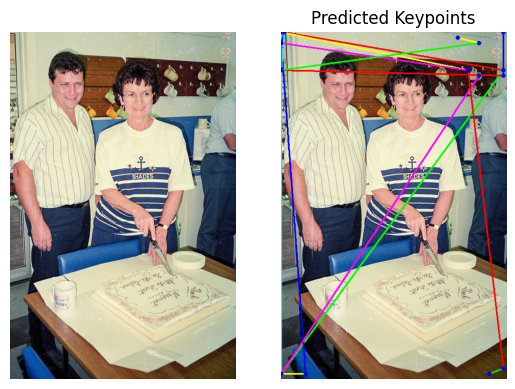

In [26]:
# --- Preprocess Image ---
def preprocess_image(img_path):
    image = Image.open(img_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    # plt.imshow(image)
    return transform(image).unsqueeze(0), image  # return tensor and original PIL

# --- Extract (x, y) from heatmaps ---
def get_keypoints_from_heatmaps(image_pil, heatmaps):
    heatmaps = heatmaps.squeeze(0).cpu().numpy()  # [17, 64, 64]
    keypoints = []

    for hmap in heatmaps:
        idx = np.unravel_index(np.argmax(hmap), hmap.shape)
        y, x = idx  # (row, col)
        # Scale to 256x256 image
        # x = int(x * 4)
        # y = int(y * 4)
        # Get image and heatmap size
        # print(hmap.shape)
        heatmap_H, heatmap_W = hmap.shape  # typically 64x64
        # print(heatmap_H,heatmap_W)
        image_W, image_H = image_pil.size  # PIL returns (width, height)

        scale_x = image_W / heatmap_W
        scale_y = image_H / heatmap_H

        # Convert heatmap coords → image coords
        x = int(x * scale_x)
        y = int(y * scale_y)

        keypoints.append((x, y))

    return keypoints

# --- Draw keypoints on image ---
"""
def draw_keypoints(image_pil, keypoints):
    img = np.array(image_pil)
    for (x, y) in keypoints:
        cv2.circle(img, (x, y), 4, (255, 0, 0), -1)
    return img
"""

def draw_keypoints(image_pil, keypoints, draw_skeleton=True):
    import cv2
    img = np.array(image_pil).copy()

    # # Draw keypoints
    # for (x, y) in keypoints:
    #     cv2.circle(img, (x, y), 4, (255, 0, 0), -1)  # dot

    # for i, j in COCO_SKELETON:
    #     if i < len(keypoints) and j < len(keypoints):
    #         xi, yi = keypoints[i]
    #         xj, yj = keypoints[j]
    #         cv2.line(img, (xi, yi), (xj, yj), (0, 255, 0), 2)  # Green line

    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255),
              (255, 255, 0), (0, 255, 255), (255, 0, 255)]  # reuse as needed

    # Draw limbs
    for i, (p1, p2) in enumerate(COCO_SKELETON):
        x1, y1 = keypoints[p1]
        x2, y2 = keypoints[p2]
        cv2.line(img, (x1, y1), (x2, y2), colors[i % len(colors)], 2)

    # Draw keypoints
    for x, y in keypoints:
        cv2.circle(img, (x, y), 4, (0, 0, 255), -1)

    return img

# --- Inference Pipeline ---
def run_demo(image_path):
    input_tensor, original_image = preprocess_image(image_path)
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        output_heatmaps = model(input_tensor)  # [1, 17, 64, 64]
        # keypoints = get_keypoints_from_heatmaps(output_heatmaps)
        keypoints = get_keypoints_from_heatmaps(original_image,output_heatmaps)
        result_img = draw_keypoints(original_image, keypoints)

    # --- Show Output ---

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(original_image)
    axs[0].axis('off')
    plt.title("Original Image")
    axs[1].imshow(result_img)
    # axs[1, 1].scatter(x, y)

    # plt.imshow(result_img)
    plt.axis('off')
    plt.title("Predicted Keypoints")
    plt.show()

# --- Run Demo ---
if __name__ == '__main__':
    run_demo("your_image.jpg")

In [15]:
torch.save(model, 'full_model_beta.pth')  # saves entire model class + weights

## Video Demo

In [27]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [29]:
def process_video(video_path, output_path='output_pose.mp4'):
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    FPS = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, FPS, (W, H))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess frame
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image_pil = Image.fromarray(frame_rgb)
        image_tensor = transform(image_pil).unsqueeze(0).to(device)

        # Inference
        with torch.no_grad():
            heatmaps = model(image_tensor)

        # Extract keypoints & draw
        # keypoints = get_keypoints_from_heatmaps(heatmaps, W, H)
        keypoints = get_keypoints_from_heatmaps(image_pil,heatmaps)
        frame_out = draw_keypoints(frame, keypoints)

        out.write(frame_out)

    cap.release()
    out.release()
    print(f"[✓] Output saved to {output_path}")

# ---- Run It ----
if __name__ == "__main__":
    process_video("inputs/Sample.mp4", output_path="outputs/output_pose.mp4")

[✓] Output saved to outputs/output_pose.mp4
